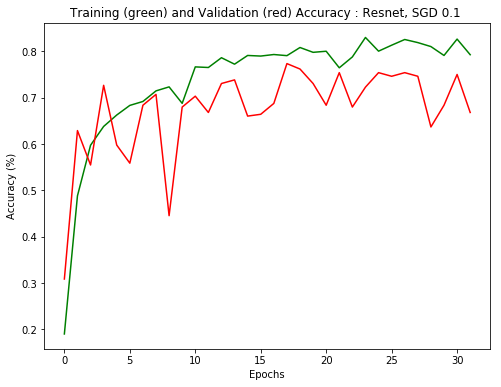

In [10]:
#### TO BE DELETED

%matplotlib inline
import matplotlib.pyplot as plt
import json

plt.figure(figsize = (8,6))
plt.title('Training (green) and Validation (red) Accuracy : Resnet, SGD 0.1 ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(deep_net.tr_accuracy, 'g')
plt.plot(deep_net.val_accuracy, 'r')
accuracies = {'training':deep_net.tr_accuracy, 'validation':deep_net.val_accuracy}

plt.savefig('plots/deep_net_adam.png', bbox_inches='tight', pad_inches=0)
torch.save(deep_net.state_dict(), open('models/deep_net_adam.pt','wb'))
json.dump(accuracies, open('models/deep_net_resnet_acc.np','w'))

# The Data

## Retrieve the data

See flickr_crawler.py . 
There are many available APIs for websites like Flickr, Google, Bing, Twitter that allows to crawl through content and download available images based on queries.
For this experiment, we want to recognize fruits in photos. Some samples of the data retrieved: 
    
<table><tr><td><img src='images/train/cherry/img0000.jpg' width=80></td><td><img src='images/train/cherry/img0003.jpg' width=80></td><td><img src='images/train/banana/img0000.jpg' width=80></td><td><img src='images/train/banana/img00011.jpg' width=80></td><td><img src='images/train/pineapple/img0000.jpg' width=80></td><td><img src='images/train/pineapple/img0007.jpg' width=80></td><td><img src='images/train/lemon/img0000.jpg' width=80></td><td><img src='images/train/lemon/img0002.jpg' width=80></td><td><img src='images/train/lychee/img0000.jpg' width=80></td><td><img src='images/train/lychee/img0001.jpg' width=80></td><td><img src='images/train/blackberry/img0001.jpg' width=80></td><td><img src='images/train/blackberry/img0004.jpg' width=80></td></tr></table>

It's not perfect but it works ! 

## Format and load the data

We will use PyTorch functionalities for this. With PyTorch, two modules you should know about for data handling:
 - Dataset : where and how to access your data. Is your data images, arrays, is it labelled, shoud it be transformed ...
 - Dataloader : load the dataset. Can transfer it directly to the GPU for faster training execution

In [1]:
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

data_transforms = {
            'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
            'val': transforms.Compose([transforms.Resize((224,224)),
                                        #transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        }
batch_size = 32

In [3]:
train_dataset = datasets.ImageFolder('images/train', data_transforms['train'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_dataset = datasets.ImageFolder('images/test', data_transforms['val'])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)


# Build the architecture

## A small example with the perceptron

Once again we will work with PyTorch classes. PyTorch allows you to build your own Modules (aka networks), your own Losses, while inheriting the features of Modules and Losses classes.
We can build a multilayer perceptron to see how it's done :

<img src="https://www.oreilly.com/library/view/getting-started-with/9781786468574/graphics/B05474_04_05.jpg">

In [12]:
import torch
from torch import nn

class myPerceptron(nn.Module):
    def __init__(self, nb_inputs, nb_hidden_1, nb_hidden_2, nb_outputs):
        super().__init__()
        self.add_module("linear1", nn.Linear(nb_inputs, nb_hidden_1))
        self.add_module("activation1", nn.ReLU())
        self.add_module("linear2", nn.Linear(nb_hidden_1, nb_hidden_2))
        self.add_module("activation2", nn.Tanh())
        self.add_module("output", nn.Linear(nb_hidden_2, nb_outputs))
        self.add_module("softmax", nn.Softmax(dim=0))

    def forward(self, input):
        x = input
        for module in self.children():
            x = module.forward(x)
        return x
    
myperceptron = myPerceptron(4, 16, 8, 2)
input = torch.randn(4)
myperceptron.forward(input)

tensor([0.4998, 0.5002], grad_fn=<SoftmaxBackward>)

In [4]:
# exercice : create your perceptron and train it with the sonar data (sonar_data.csv)

## What about deep convolutional neural networks ...

PyTorch.torchvision come with several already implemented famous CNN architectures. These models are also pretrained on ImageNet, which can significally speed up the learning process. 
Let's see what is inside a VGG for example:

In [13]:
models.vgg11()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [6]:
# explain backward , variables, tensors ???

## Our deep network architecture

Head over to the models.py file and find the DeepNet class. It includes:
 - a basemodel (resnet, vgg, or alexnet) pretrained on ImageNet for feature extraction
 - the modified last layer for finetuning a basemodel on our data
 - functions to forward, predict, and train the model

## Learn the network

In [22]:
from models import DeepNet

CUDA_AVAILABLE = torch.cuda.is_available()
NB_CLASSES = 16
NUM_EPOCHS = 16

# 1 Create the deep net
deep_net = DeepNet('resnet', NB_CLASSES, full_backprop=False)
# 2 Select a loss. CrossEntropyLoss is recommended for multiclass problems.
criterion = torch.nn.CrossEntropyLoss()
# 3 Select an optimizer. This will update the weights in the network during the backpropagation
# You can try with Adam, RMSProp, SGD with different learning rates and parameters...
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,deep_net.parameters()))
# 4 Train the deep_net
if CUDA_AVAILABLE:
    deep_net.fit(train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, verbose=False)

Below are several examples of how the training went and performed for several optimizers, optimizer parameters, and architectures. You can plot your own results with `plt.plot(deep_net.tr_accuracy)` and `plt.plot(deep_net.val_accuracy)`

        Training and validation accuracies over epochs for Alexnet, VGG, Resnet as basemodels.
<table><tr><td><img src='plots/deep_net_alexnet.png', width='400'></td><td><img src='plots/deep_net_vgg.png', width=400></td><td><img src='plots/deep_net_adam.png', width=400></td></tr></table>

                    Different learning rates for the stochastic gradient, and with momentum or not
<table><tr><td><img src='plots/deep_net_fc_sgd01.png', width='400'></td><td><img src='plots/deep_net_fc_sgd0001.png', width=400></td><td><img src='plots/deep_net_fc_sgd0001m.png', width=400></td></tr></table>

if you want to avoid training your own model, or if you don't have a GPU, you can load a pre-trained model by executing the cell below

In [23]:
from models import DeepNet

deep_net = DeepNet('resnet', 16, full_backprop=False)
if CUDA_AVAILABLE:
    deep_net.load_state_dict(torch.load('models/deep_net_fc_adam.pt'))
else:
    deep_net.load_state_dict(torch.load('models/deep_net_fc_adam.pt', map_location=lambda storage, loc: storage))

## Test the network

We will now test in inference with new and different images, from Bing and some photos I took myself. You could test with your own pictures of fruits by adding the .jpg in the test_images folder.
The inference process is as follows:
 - retrieve the images in the local folder, and compute the path (for opening and visualisation purposes)
 - open the images (with PIL library)
 - transforms the images (now in bytes) into tensors. This is done with the data_transforms we introduced above
 
 - set the network in 'eval' mode. This avoids unnecessary gradient computations, since we are not trying to 'learn' anything at this stage
 - use the predict() function on the inferences images. The result is a prediction and its probability for each image

In [20]:
import os
from PIL import Image
images = [files for root, dirs, files in os.walk('test_images/')][0]
images_paths = ['test_images/'+im for im in images]
images_objects = [Image.open(im) for im in images_paths]
tensors = torch.stack([data_transforms['train'](im) for im in images_objects])

deep_net.eval()
probabilities, predictions = deep_net.predict(tensors)

In [24]:
from IPython.display import HTML, Image, display

def display_image_prediction(image_path, prediction, probability):
    imageQuery = "<img style='margin: 1px; width:200px; float: left; border: 1px solid ;' src={} '/>".format(
        image_path)
    display(HTML(imageQuery))
    print('Prediction: {}, {}\n'.format(prediction, probability))
    
for i in range(len(predictions)):
    prediction = train_dataset.classes[predictions[i].item()]
    probability = round(100*probabilities[i].item(), 1)
    display_image_prediction(images_paths[i], prediction, probability)

Prediction: durian, 95.6



Prediction: apple, 93.5



Prediction: tangerine, 93.1



Prediction: avocado, 81.3



Prediction: avocado, 93.8



Prediction: grape, 89.8



Prediction: tangerine, 99.0



Prediction: durian, 99.9



Prediction: cherry, 41.9



Prediction: avocado, 69.9



Prediction: apple, 49.3



Prediction: durian, 93.9



Prediction: watermelon, 88.4



Prediction: banana, 94.7



Prediction: banana, 99.4



Prediction: cherry, 92.2



Prediction: pineapple, 17.5



Prediction: tangerine, 71.9



Prediction: banana, 98.4



Prediction: cherry, 89.3



Prediction: blackberry, 88.0



Prediction: blackberry, 96.2



Prediction: blackberry, 99.1



Prediction: blackberry, 94.8



Prediction: grape, 96.6



Prediction: lychee, 55.4



Prediction: kiwi, 80.2



Prediction: tomato, 42.5



Prediction: kiwi, 47.9



Prediction: lychee, 63.0



Prediction: watermelon, 97.2



Prediction: strawberry, 72.1



Prediction: kiwi, 96.0



Prediction: peaches, 98.9



Prediction: peaches, 93.7



Prediction: watermelon, 92.2



Prediction: grape, 87.1



Prediction: tomato, 99.9



Prediction: lemon, 79.9



Prediction: strawberry, 99.8



Prediction: strawberry, 100.0



Prediction: lemon, 86.6



Prediction: strawberry, 100.0



Prediction: pineapple, 96.6



Prediction: pineapple, 53.0



Prediction: pineapple, 99.7



Prediction: tomato, 96.6



Prediction: banana, 82.7



Prediction: tomato, 99.1

